In [1]:
# !pip install -U scikit-learn

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datos_2c2020_tp2.models.log.Logger as logger


# TP2 - XGBoost example

El objetivo es crear un primer modelo básico de XGBoost, sin feature engineering ni hyperparameters tunning, para poder tener un primer resultado local. Luego, realizar un primer submit en kaggle y en base a eso ir mejorando el modelo

In [3]:
train = pd.read_csv("../datasets/xgb-train.csv")
test = pd.read_csv("../datasets/xgb-test.csv")

train['Month'] = pd.to_datetime(train['Month']).dt.month
test['Month'] = pd.to_datetime(test['Month']).dt.month

In [4]:
test.head(2)

,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Opportunity_ID,ASP,ASP_(converted),Month,Delivery_Year,TRF,...,Product_Name_6,Product_Name_7,Product_Name_8,Billing_Country_0,Billing_Country_1,Billing_Country_2,Billing_Country_3,Billing_Country_4,Billing_Country_5,Billing_Country_6
0,1,1,1,1,10689,0.325,0.36761,1,2019,0,...,0,0,0,0,0,1,1,0,1,1
1,1,1,1,1,10689,0.320,0.36195,1,2019,0,...,0,0,1,0,0,1,1,0,1,1


In [5]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
              colsample_bytree = 0.3, learning_rate = 0.1,
              max_depth = 8, alpha = 20, n_estimators = 160)

In [6]:
target = "target"
features = list(train.columns)
features.remove(target)
features.remove("Opportunity_ID")
len(features)


117

In [7]:
X_train, y_train = train.loc[:,features],train.loc[:,target]
X_test_Opp = test.loc[:,"Opportunity_ID"]
X_test = test.loc[:,features]



In [8]:
print(X_train.shape)
print(X_test.shape)

(16947, 117)
(2551, 117)


In [9]:


xg_reg.fit(X_train,y_train)


XGBRegressor(alpha=20, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=160, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
preds = xg_reg.predict(X_test)


In [11]:
pred_df = pd.DataFrame(X_test_Opp)
pred_df["Target"] = preds
pred_df = pred_df.drop_duplicates("Opportunity_ID")
pred_df
pred_df.to_csv("../submits/xgb_model_preprocessed.csv",index=False)

#

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

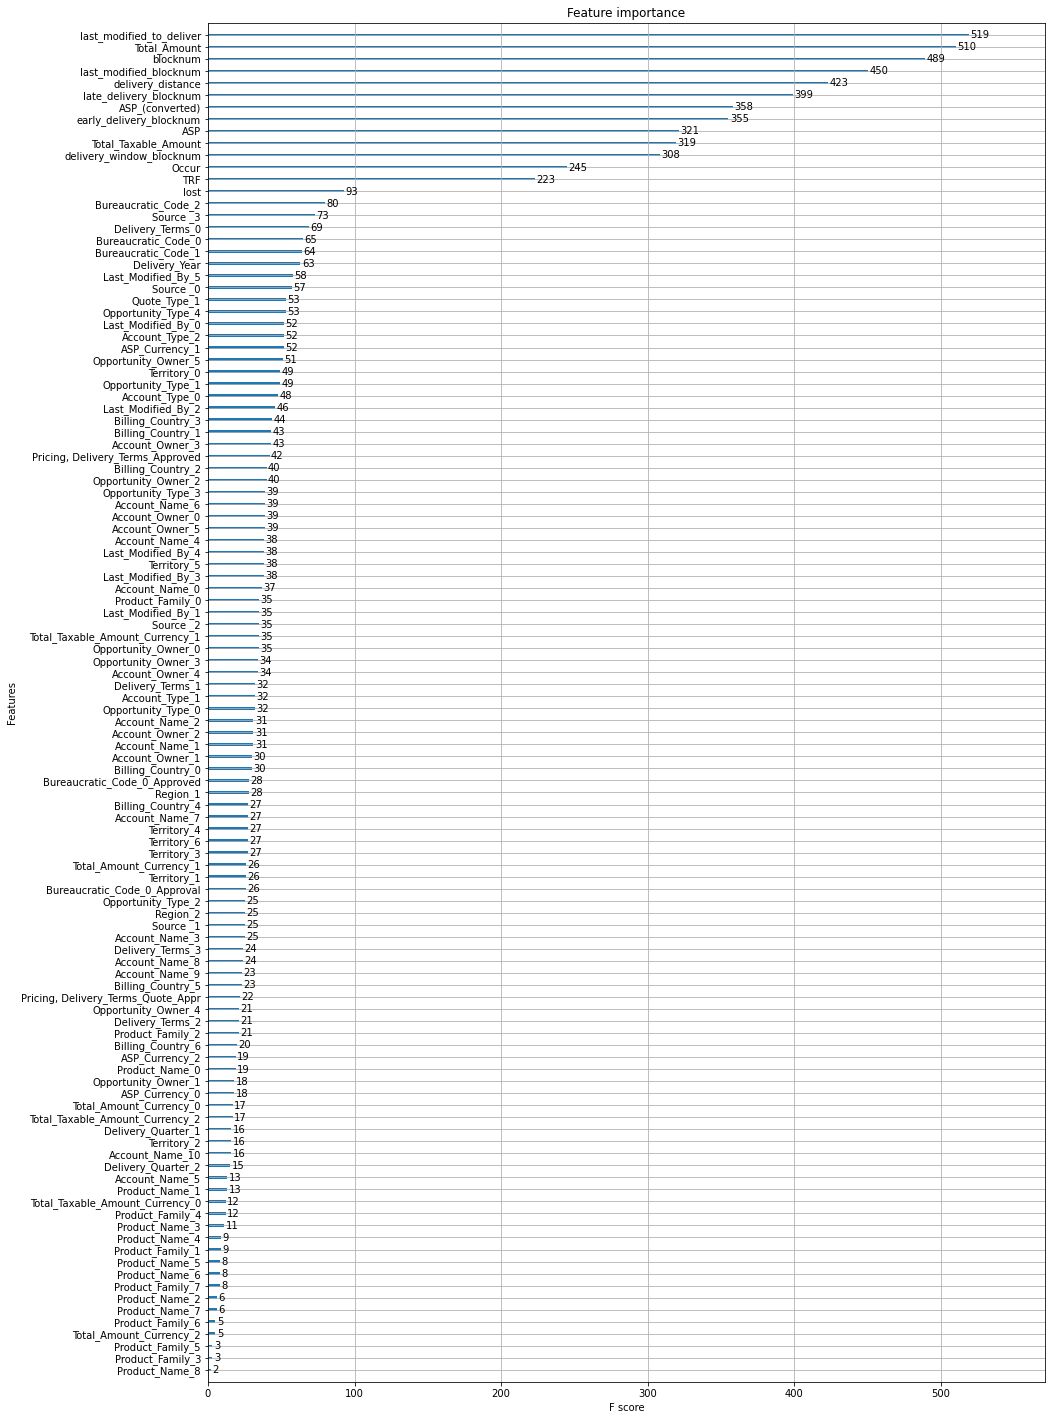

In [12]:
plt.rcParams['figure.figsize'] = [15, 25]
xgb.plot_importance(xg_reg)



In [13]:

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 8, 'alpha': 10}



cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=23939)
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
45,0.276316,0.002242,0.297177,0.001480
46,0.275505,0.002427,0.296599,0.001381
47,0.274701,0.002470,0.296030,0.001343
48,0.273919,0.002540,0.295534,0.001470
49,0.273042,0.002626,0.294932,0.001370


In [14]:
cv_score = (cv_results["test-rmse-mean"]).tail(1)

print(cv_score)


49    0.294932
Name: test-rmse-mean, dtype: float64


In [15]:
logger.Logger.log_model("xgb", params, features, cv_score)

TypeError: type dict doesn't define __round__ method